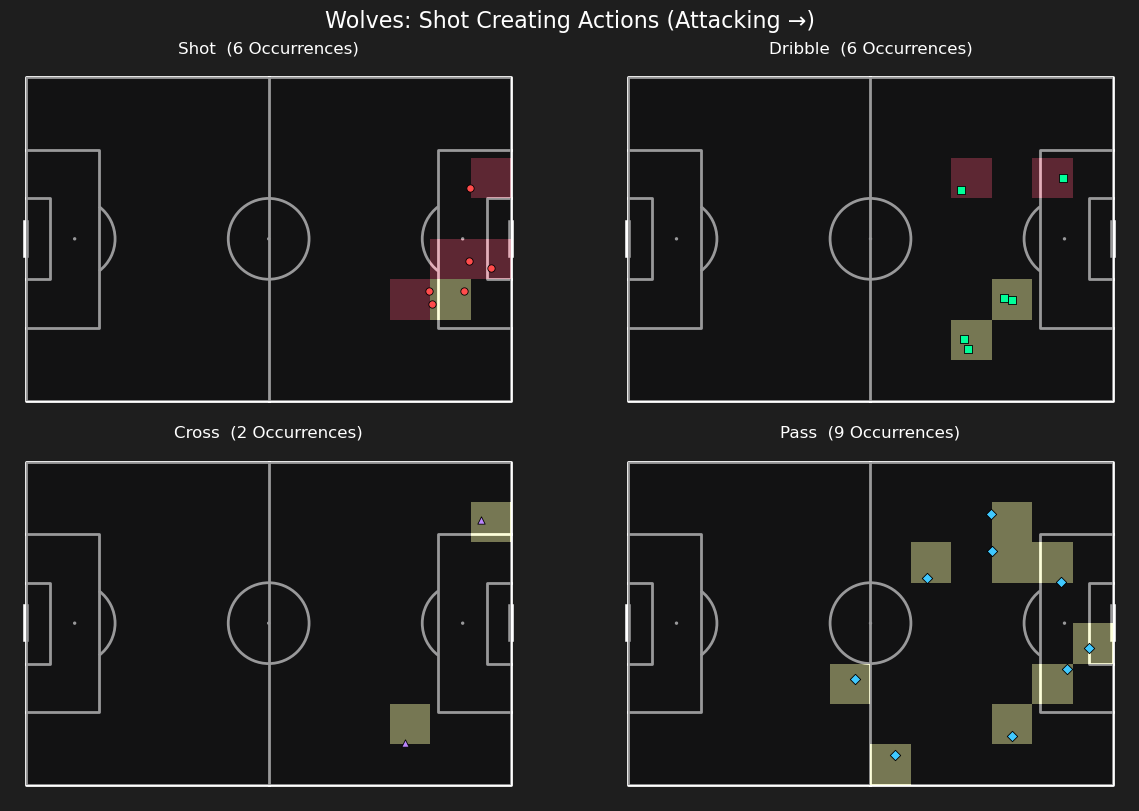

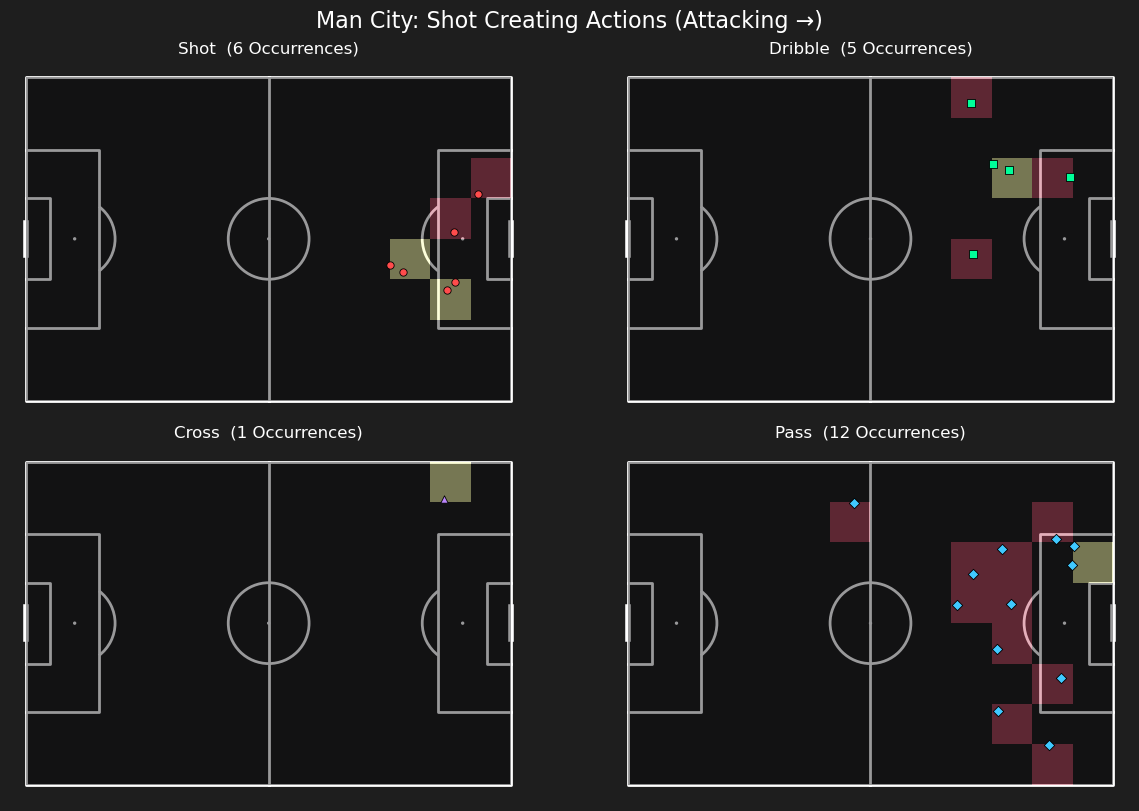

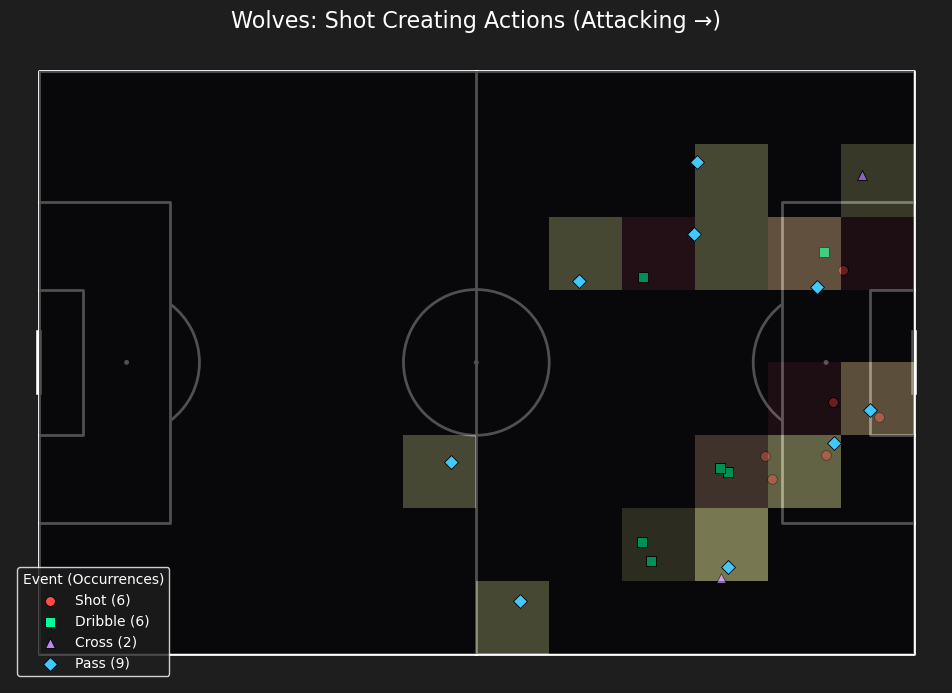

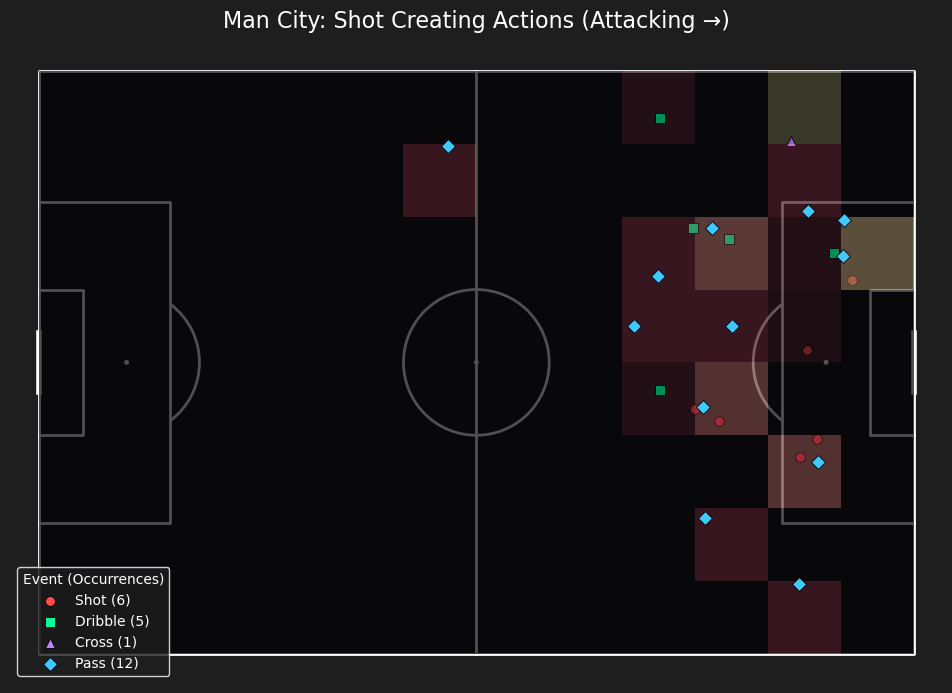

In [2]:
# !pip install mplsoccer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

file_path = "prevGameSCA.xlsx"  #change file here
df = pd.read_excel(file_path, sheet_name="Sheet1")

normalize = {
    "shot": "Shot", "shots": "Shot",
    "dribble": "Dribble", "dribbles": "Dribble",
    "cross": "Cross", "crosses": "Cross",
    "pass": "Pass", "passes": "Pass"
}
df["Event"] = df["Event"].astype(str).str.strip().str.lower().map(normalize).fillna(df["Event"])

df["X_sb"] = (df["X"].astype(float) * 1.2).clip(0, 120)
df["Y_sb"] = (df["Y"].astype(float) * 0.8).clip(0, 80)

wolves_df = df[df["Team"].str.strip().str.lower() == "wolves"].copy()
city_df   = df[df["Team"].str.strip().str.lower() != "wolves"].copy()


wolves_df_flip = wolves_df.copy()
wolves_df_flip["X_sb"] = 120 - wolves_df_flip["X_sb"]

event_order = ["Shot", "Dribble", "Cross", "Pass"]
event_markers = {"Shot": "o", "Dribble": "s", "Cross": "^", "Pass": "D"}
event_colors = {
    "Shot": "#ff4c4c",   
    "Dribble": "#00ff99",   
    "Cross": "#bb86fc",     
    "Pass": "#40c9ff",   
}

def add_jitter(x, y, scale_x=0.3, scale_y=0.2, seed=42):
    rng = np.random.default_rng(seed)
    return x + rng.normal(0, scale_x, size=len(x)), y + rng.normal(0, scale_y, size=len(y))

def panel(ax, data, title):
    pitch = Pitch(pitch_type="statsbomb", pitch_color="#1e1e1e", line_color="white")
    pitch.draw(ax=ax)

    if not data.empty:
        bs = pitch.bin_statistic(
            data["X_sb"].values, data["Y_sb"].values,
            statistic='count', bins=(12, 8)
        )
        pitch.heatmap(bs, ax=ax, cmap="inferno", edgecolors=None, alpha=0.4)
        xj, yj = add_jitter(data["X_sb"].values, data["Y_sb"].values)
        pitch.scatter(
            xj, yj, ax=ax, s=28, marker=event_markers[title],
            c=event_colors[title], edgecolors="black", linewidths=0.6, zorder=3
        )

    ax.set_title(f"{title}  ({len(data)} Occurrences)", fontsize=12, pad=6, color="white")

def plot_team_grid(team_name, team_df):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True, facecolor="#1e1e1e")
    axes = axes.ravel()

    for i, evt in enumerate(event_order):
        sub = team_df[team_df["Event"] == evt]
        panel(axes[i], sub, evt)

    fig.suptitle(f"{team_name}: Shot Creating Actions (Attacking →)", fontsize=16, color="white")
    plt.show()

def plot_combined(team_name, team_df):
    pitch = Pitch(pitch_type="statsbomb", pitch_color="#1e1e1e", line_color="white")
    fig, ax = pitch.draw(figsize=(10, 7))
    fig.set_facecolor("#1e1e1e")

    handles = []
    for evt in event_order:
        sub = team_df[team_df["Event"] == evt]
        if sub.empty:
            continue
        bs = pitch.bin_statistic(sub["X_sb"].values, sub["Y_sb"].values, statistic='count', bins=(12, 8))
        pitch.heatmap(bs, ax=ax, cmap="inferno", edgecolors=None, alpha=0.25)
        xj, yj = add_jitter(sub["X_sb"].values, sub["Y_sb"].values, scale_x=0.25, scale_y=0.18, seed=7)
        sc = pitch.scatter(
            xj, yj, ax=ax, s=50, marker=event_markers[evt],
            c=event_colors[evt], edgecolors="black", linewidths=0.6,
            label=f"{evt} ({len(sub)})"
        )
        handles.append(sc)

    ax.set_title(f"{team_name}: Shot Creating Actions (Attacking →)", fontsize=16, pad=10, color="white")
    if handles:
        leg = ax.legend(loc="lower left", frameon=True, title="Event (Occurrences)",
                        labelcolor="white", facecolor="#1e1e1e", edgecolor="white")
        leg.get_title().set_color("white")
    plt.show()

plot_team_grid("Wolves", wolves_df_flip)
plot_team_grid("Man City", city_df)

plot_combined("Wolves", wolves_df_flip)
plot_combined("Man City", city_df)


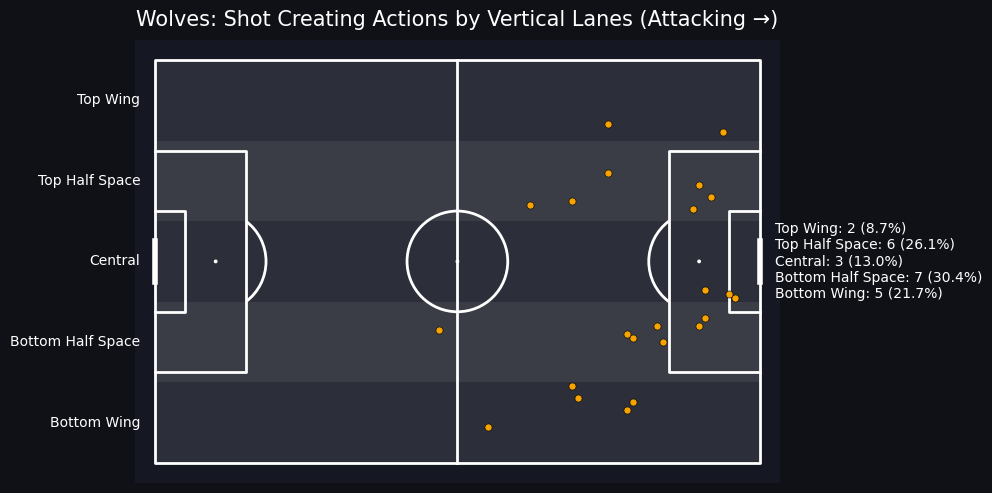

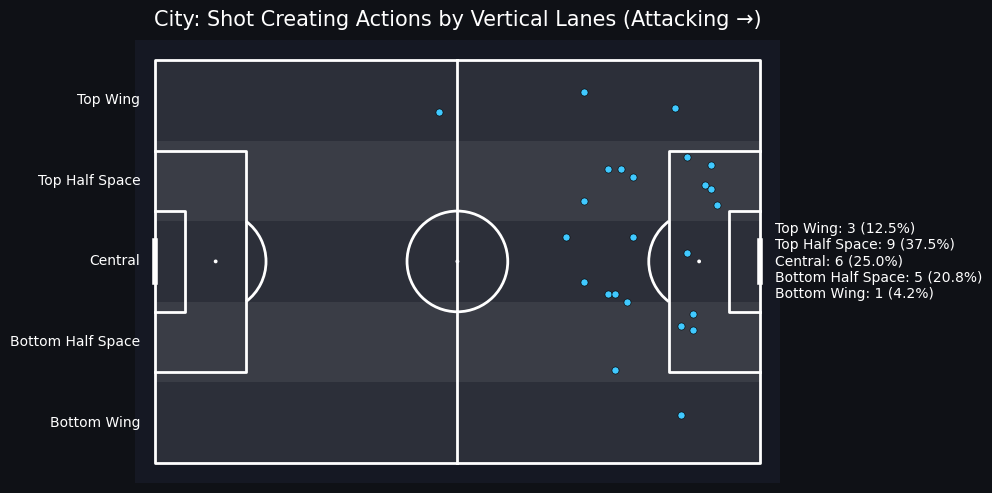

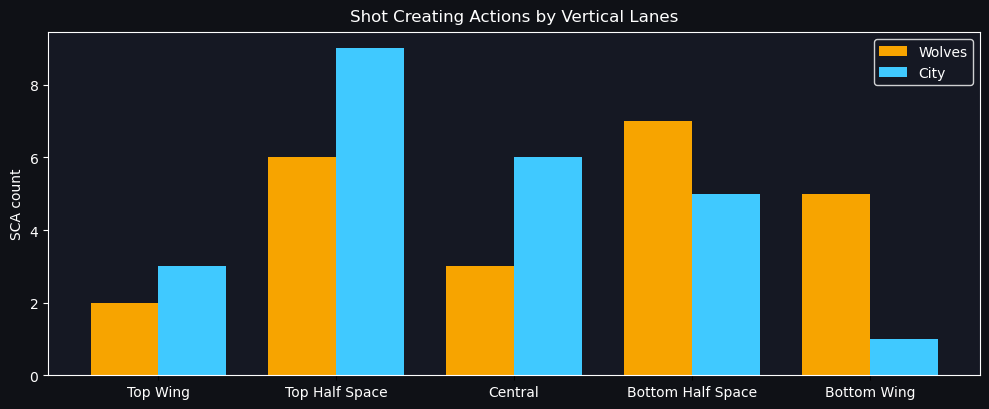

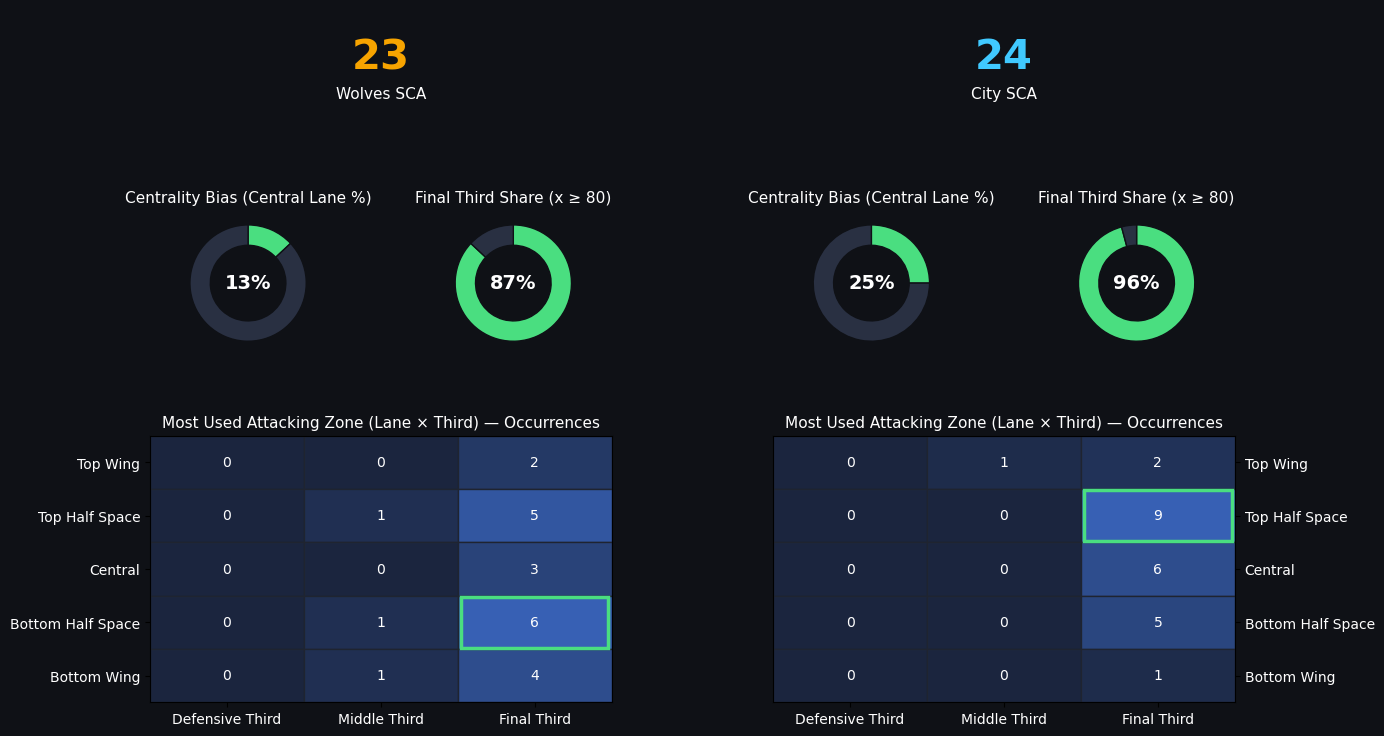

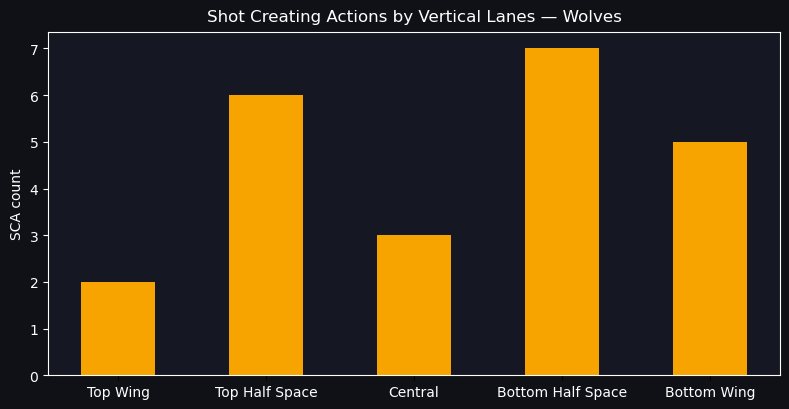

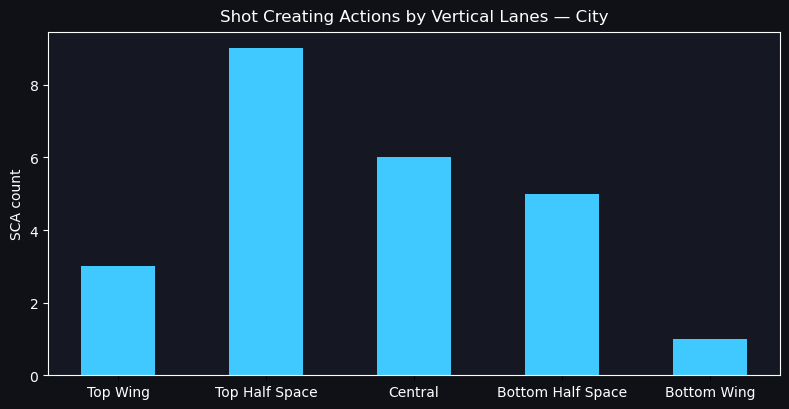

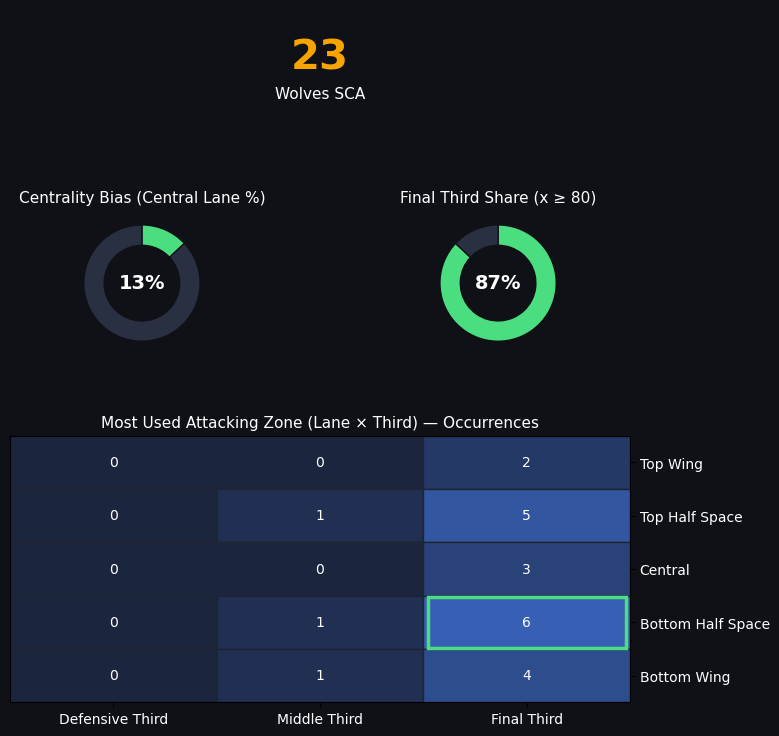

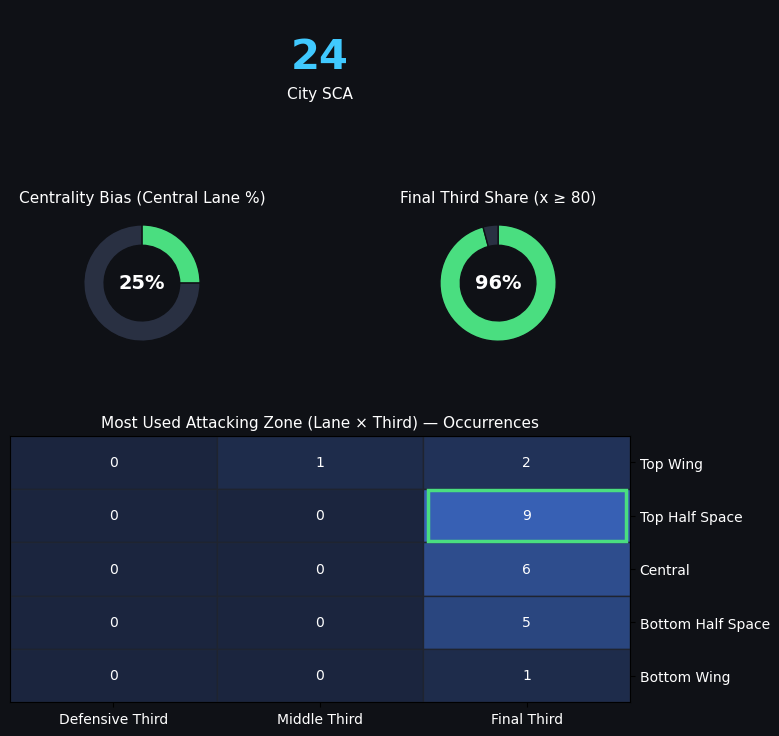

In [26]:
#!pip install mplsoccer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mplsoccer import Pitch

FILE = "prevGameSCA.xlsx"
SHEET = "Sheet1"

df = pd.read_excel(FILE, sheet_name=SHEET)

normalize = {
    "shot": "Shot", "shots": "Shot",
    "dribble": "Dribble", "dribbles": "Dribble",
    "cross": "Cross", "crosses": "Cross",
    "pass": "Pass", "passes": "Pass"
}
df["Event"] = df["Event"].astype(str).str.strip().str.lower().map(normalize).fillna(df["Event"])

df["X_sb"] = (df["X"].astype(float) * 1.2).clip(0, 120)
df["Y_sb"] = (df["Y"].astype(float) * 0.8).clip(0, 80)

wolves_df = df[df["Team"].str.strip().str.lower() == "wolves"].copy()
opp_df    = df[df["Team"].str.strip().str.lower() != "wolves"].copy()
opp_name  = opp_df["Team"].mode().iat[0] if not opp_df.empty else "Opponent"

wolves_df_flipped = wolves_df.copy()
wolves_df_flipped["X_sb"] = 120 - wolves_df_flipped["X_sb"]

LANE_NAMES  = ["Top Wing", "Top Half Space", "Central", "Bottom Half Space", "Bottom Wing"]
LANE_EDGES  = np.linspace(0, 80, 6)
THIRD_NAMES = ["Defensive Third", "Middle Third", "Final Third"]
THIRD_EDGES = [0, 40, 80, 120]

FIG_BG = "#0f1116"
AX_BG  = "#151823"
LINES  = "white"

def lane_from_y(y):
    return int(np.clip(np.digitize(y, LANE_EDGES, right=False) - 1, 0, 4))

def third_from_x(x):
    return int(np.clip(np.digitize(x, THIRD_EDGES, right=False) - 1, 0, 2))

def add_lane_label(ax, lane_idx, color="white"):
    y0, y1 = LANE_EDGES[lane_idx], LANE_EDGES[lane_idx+1]
    yc = (y0 + y1) / 2
    ax.text(-3, yc, LANE_NAMES[lane_idx], va="center", ha="right", color=color, fontsize=10)

def count_by_lane(df_in):
    if df_in.empty:
        return pd.Series(0, index=LANE_NAMES)
    lanes = df_in["Y_sb"].apply(lane_from_y)
    return (
        pd.Series(lanes)
        .value_counts()
        .reindex(range(5), fill_value=0)
        .rename(index=dict(enumerate(LANE_NAMES)))
        .astype(int)
    )

def plot_lanes_with_points(team_name, team_df, point_size=26, point_color="lightgreen"):
    pitch = Pitch(pitch_type="statsbomb", pitch_color=AX_BG, line_color=LINES)
    fig, ax = pitch.draw(figsize=(10, 7))
    fig.set_facecolor(FIG_BG)

    for i in range(5):
        y0, y1 = LANE_EDGES[i], LANE_EDGES[i+1]
        alpha = 0.10 if i % 2 == 0 else 0.16
        rect = Rectangle((0, y0), 120, y1 - y0, fc="white", ec=None, alpha=alpha, zorder=0)
        ax.add_patch(rect)
        add_lane_label(ax, i, color="white")

    if not team_df.empty:
        pitch.scatter(
            team_df["X_sb"], team_df["Y_sb"],
            ax=ax, s=point_size, c=point_color,
            edgecolors="black", linewidths=0.4, zorder=3
        )

    lane_counts = count_by_lane(team_df)
    total = int(len(team_df))
    lines = [f"{ln}: {int(c)} ({(c/total*100 if total else 0):.1f}%)" for ln, c in lane_counts.items()]
    ax.text(123, 40, "\n".join(lines), va="center", ha="left", color="white", fontsize=10)

    ax.set_title(f"{team_name}: Shot Creating Actions by Vertical Lanes (Attacking →)", color="white", fontsize=15, pad=10)
    plt.show()
    return lane_counts

def plot_lane_bars(wolves_counts, opp_counts, opp_label):
    idx = LANE_NAMES
    wc = wolves_counts.reindex(idx, fill_value=0).astype(int)
    oc = opp_counts.reindex(idx, fill_value=0).astype(int)
    x = np.arange(len(idx))
    width = 0.38
    fig, ax = plt.subplots(figsize=(10, 4.2), facecolor=FIG_BG)
    ax.set_facecolor(AX_BG)
    ax.bar(x - width/2, wc.values, width, label="Wolves", color="#f7a400")
    ax.bar(x + width/2, oc.values, width, label=opp_label, color="#40c9ff")
    ax.set_xticks(x)
    ax.set_xticklabels(idx, rotation=0, ha="center", color="white")
    ax.set_ylabel("SCA count", color="white")
    ax.tick_params(axis="y", colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")
    leg = ax.legend(facecolor=AX_BG, edgecolor="white")
    for text in leg.get_texts():
        text.set_color("white")
    ax.set_title("Shot Creating Actions by Vertical Lanes", color="white", pad=8)
    plt.tight_layout()
    plt.show()

def summary_components(team_df):
    total = int(len(team_df))
    if total == 0:
        return {
            "total": 0,
            "central_share": 0.0,
            "final_third_share": 0.0,
            "grid_counts": np.zeros((5, 3), dtype=int),
            "most_used": (2, 2)
        }
    lanes  = team_df["Y_sb"].apply(lane_from_y).to_numpy()
    thirds = team_df["X_sb"].apply(third_from_x).to_numpy()
    central_share = (lanes == 2).mean()
    final_third_share = (team_df["X_sb"] >= 80).mean()
    grid = np.zeros((5, 3), dtype=int)
    for l, t in zip(lanes, thirds):
        grid[l, t] += 1
    l_idx, t_idx = np.unravel_index(np.argmax(grid), grid.shape)
    return {
        "total": total,
        "central_share": float(central_share),
        "final_third_share": float(final_third_share),
        "grid_counts": grid,
        "most_used": (l_idx, t_idx)
    }

def donut(ax, share, title, label_inside=True):
    ax.set_facecolor(AX_BG)
    ax.pie(
        [share, 1 - share],
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.35, edgecolor=FIG_BG),
        colors=["#4ade80", "#293042"],
    )
    if label_inside:
        ax.text(0, 0, f"{share*100:.0f}%", ha="center", va="center", color="white", fontsize=14, fontweight="bold")
    ax.set_title(title, color="white", fontsize=11, pad=6)

def big_metric(ax, value, title, color="#e5e7eb"):
    ax.set_facecolor(AX_BG)
    ax.axis("off")
    ax.text(0.5, 0.60, str(value), ha="center", va="center", color=color, fontsize=30, fontweight="bold")
    ax.text(0.5, 0.30, title, ha="center", va="center", color="white", fontsize=11)

def heatmap_zone(ax, grid_counts, highlight, title, y_labels_side="left",
                 highlight_inset=0.03, cell_width=1.4, cell_height=1.2):
    ax.set_facecolor(AX_BG)
    ax.set_title(title, color="white", fontsize=11, pad=6)
    n_rows, n_cols = grid_counts.shape
    total_width = n_cols * cell_width
    total_height = n_rows * cell_height
    ax.set_xticks([c * cell_width for c in range(n_cols)])
    ax.set_xticklabels(THIRD_NAMES, color="white", rotation=0)
    ax.set_yticks([r * cell_height for r in range(n_rows)])
    ax.set_yticklabels(LANE_NAMES, color="white")
    if y_labels_side == "right":
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.tick_params(axis='y', labelleft=False, labelright=True)
    else:
        ax.yaxis.tick_left()
        ax.yaxis.set_label_position("left")
        ax.tick_params(axis='y', labelright=False, labelleft=True)
    vmax = max(grid_counts.max(), 1)
    for i in range(n_rows):
        for j in range(n_cols):
            val = grid_counts[i, j]
            shade = 0.15 + 0.65 * (val / vmax)
            ax.add_patch(
                Rectangle((j * cell_width - cell_width/2,
                           i * cell_height - cell_height/2),
                          cell_width, cell_height,
                          facecolor=(0.25, 0.45, 0.85, shade),
                          edgecolor="#1f2430",
                          linewidth=1.0,
                          zorder=1)
            )
            ax.text(j * cell_width, i * cell_height, str(val),
                    ha="center", va="center", color="white", fontsize=10, zorder=2)
    li, tj = highlight
    x0 = (tj * cell_width - cell_width/2) + highlight_inset
    y0 = (li * cell_height - cell_height/2) + highlight_inset
    w  = cell_width - 2 * highlight_inset
    h  = cell_height - 2 * highlight_inset
    ax.add_patch(
        Rectangle((x0, y0), w, h,
                  fill=False,
                  edgecolor="#4ade80",
                  linewidth=2.5,
                  zorder=10,
                  snap=True)
    )
    ax.set_xlim(-cell_width/2, total_width - cell_width/2)
    ax.set_ylim(total_height - cell_height/2, -cell_height/2)
    ax.grid(False)

def plot_summary_dashboard(w_sum, o_sum, opp_label):
    fig = plt.figure(figsize=(14, 9), facecolor=FIG_BG)
    gs = fig.add_gridspec(
        3, 2,
        height_ratios=[1.0, 1.2, 2.2],
        hspace=0.45,
        wspace=0.35
    )
    ax_w_total = fig.add_subplot(gs[0, 0])
    big_metric(ax_w_total, w_sum["total"], "Wolves SCA", color="#f7a400")
    ax_o_total = fig.add_subplot(gs[0, 1])
    big_metric(ax_o_total, o_sum["total"], f"{opp_label} SCA", color="#40c9ff")
    sub_w = gs[1, 0].subgridspec(1, 2, wspace=0.35)
    sub_o = gs[1, 1].subgridspec(1, 2, wspace=0.35)
    ax_w_central = fig.add_subplot(sub_w[0, 0])
    donut(ax_w_central, w_sum["central_share"], "Centrality Bias (Central Lane %)")
    ax_w_final = fig.add_subplot(sub_w[0, 1])
    donut(ax_w_final, w_sum["final_third_share"], "Final Third Share (x ≥ 80)")
    ax_o_central = fig.add_subplot(sub_o[0, 0])
    donut(ax_o_central, o_sum["central_share"], "Centrality Bias (Central Lane %)")
    ax_o_final = fig.add_subplot(sub_o[0, 1])
    donut(ax_o_final, o_sum["final_third_share"], "Final Third Share (x ≥ 80)")
    ax_w_heat = fig.add_subplot(gs[2, 0])
    heatmap_zone(ax_w_heat, w_sum["grid_counts"], w_sum["most_used"],
                 "Most Used Attacking Zone (Lane × Third) — Occurrences",
                 y_labels_side="left")
    ax_o_heat = fig.add_subplot(gs[2, 1])
    heatmap_zone(ax_o_heat, o_sum["grid_counts"], o_sum["most_used"],
                 "Most Used Attacking Zone (Lane × Third) — Occurrences",
                 y_labels_side="right")
    plt.show()

def plot_lane_bars_single(counts, label, color):
    idx = LANE_NAMES
    c = counts.reindex(idx, fill_value=0).astype(int)
    x = np.arange(len(idx))
    fig, ax = plt.subplots(figsize=(8, 4.2), facecolor=FIG_BG)
    ax.set_facecolor(AX_BG)
    ax.bar(x, c.values, 0.5, label=label, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(idx, rotation=0, ha="center", color="white")
    ax.set_ylabel("SCA count", color="white")
    ax.tick_params(axis="y", colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")
    ax.set_title(f"Shot Creating Actions by Vertical Lanes — {label}", color="white", pad=8)
    plt.tight_layout()
    plt.show()

def plot_summary_dashboard_single(s_sum, label, color):
    fig = plt.figure(figsize=(8, 9), facecolor=FIG_BG)
    gs = fig.add_gridspec(3, 1, height_ratios=[1.0, 1.2, 2.2], hspace=0.45)
    ax_total = fig.add_subplot(gs[0, 0])
    big_metric(ax_total, s_sum["total"], f"{label} SCA", color=color)
    sub = gs[1, 0].subgridspec(1, 2, wspace=0.35)
    ax_central = fig.add_subplot(sub[0, 0])
    donut(ax_central, s_sum["central_share"], "Centrality Bias (Central Lane %)")
    ax_final = fig.add_subplot(sub[0, 1])
    donut(ax_final, s_sum["final_third_share"], "Final Third Share (x ≥ 80)")
    ax_heat = fig.add_subplot(gs[2, 0])
    heatmap_zone(ax_heat, s_sum["grid_counts"], s_sum["most_used"], "Most Used Attacking Zone (Lane × Third) — Occurrences", y_labels_side="right")
    plt.show()

wolves_lane_counts = plot_lanes_with_points("Wolves", wolves_df_flipped, point_color="#f7a400")
opp_lane_counts    = plot_lanes_with_points(opp_name, opp_df, point_color="#40c9ff")
plot_lane_bars(wolves_lane_counts, opp_lane_counts, opp_label=opp_name)

wolves_sum = summary_components(wolves_df_flipped)
opp_sum    = summary_components(opp_df)

plot_summary_dashboard(wolves_sum, opp_sum, opp_label=opp_name)

plot_lane_bars_single(wolves_lane_counts, "Wolves", "#f7a400")
plot_lane_bars_single(opp_lane_counts, opp_name, "#40c9ff")

plot_summary_dashboard_single(wolves_sum, "Wolves", "#f7a400")
plot_summary_dashboard_single(opp_sum, opp_name, "#40c9ff")
